## Homework 8
*Author: Puri Rudick*


In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

Cluster the reviews that you collected in homework 5, by doing the following:

#### **1)** In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  

```
In Homework 5, I picked 5 movies in the adventure, fantacy, and superhero genre. All movies are from Marvel Studio. As you can see in the code block below with # to comment them out.
However, with the movies being too close in concepts to each other, they do not provide a good example for this Homework 7.

I decided to pick new 5 movies in the action genre. With different actors and movie studioes. 
I obtain the movie title_id from IMDB website and put them into a dictionary above.
I obtained first 250 user reviews for each movie then combined all of them into a dataframe.
```

In [2]:
movies = {
    # 'Avengers: Endgame': 'tt4154796',
    # 'Shang-Chi and the Legend of the Ten Rings': 'tt9376612',
    # 'Doctor Strange in the Multiverse of Madness': 'tt9419884',
    # 'Guardians of the Galaxy Vol. 2': 'tt3896198',
    # 'Spider-Man: No Way Home': 'tt10872600'
    'Thor: Love and Thunder': 'tt10648342',
    'Top Gun: Maverick': 'tt1745960',
    'Jurassic World Dominion': 'tt8041270',
    'The Batman': 'tt1877830',
    'The Man from Toronto': 'tt11671006'
}

In [3]:
def get_movie_reviews(movies, movie_tt):
    url_text = 'https://www.imdb.com/title/' + movie_tt
    url = (url_text + "/reviews/_ajax?ref_=undefined&paginationKey={}")
    key = ""
    data = {"movie_name":[], "review_title": [], "review_txt": []}

    for i in range(0,10):
        response = requests.get(url.format(key))
        soup = BeautifulSoup(response.content, "html.parser")
        # Find the pagination key
        pagination_key = soup.find("div", class_="load-more-data")
        if not pagination_key:
            break

        # Update the `key` variable in-order to scrape more reviews
        key = pagination_key["data-key"]
        for title, review in zip(soup.find_all(class_="title"), soup.find_all(class_="text show-more__control")):
            data["movie_name"].append(movies)
            data["review_title"].append(title.get_text(strip=True))
            data["review_txt"].append(review.get_text())

    review = pd.DataFrame(data)
    return review


In [4]:
df = pd.DataFrame()
for m in movies:
    review = get_movie_reviews(m, movies[m])
    df = pd.concat([df, review])

df.head()

movie_name                                       review_title  \
0  Thor: Love and Thunder                                Enjoyable but empty   
1  Thor: Love and Thunder                           Nearly a 2-hour SNL skit   
2  Thor: Love and Thunder                    Bale good, the rest kinda weak.   
3  Thor: Love and Thunder  Christian bales great performance wasted in a ...   
4  Thor: Love and Thunder                             Very very disappointed   

                                          review_txt  
0  Thor: Love and Thunder does attempt to explore...  
1  ...Well, maybe not SNL-esque throughout the fu...  
2  Fine seems to cover it, Disney has become fine...  
3  Christian Bale is great, Russell Crowe has a g...  
4  I'm a huge marvel fanboy, and hardly ever have...

In [5]:
df.shape

(1250, 3)

```
The clustering technique I chose is k-Mean clustering.

To decide the number of k, I implored the elbow method which consists of pllotting different distortions as a function of a certain number of cluster.
```

#### Vectorize Reviews using TF-IDF

In [6]:
reviews = df['review_txt'].values.astype('U')

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(stop_words = 'english')     #stop_words, ngram_range = (1,1))#transform
reviews_vec = tfv.fit_transform(reviews)           #returns a list of words.

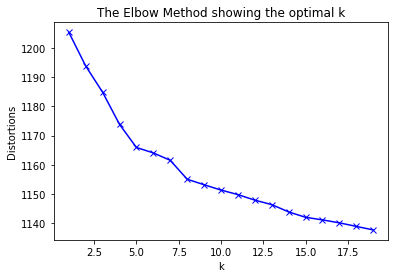

In [8]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

X = reviews_vec
K = range(1,20)

distortions = []
for k in K: 
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1, random_state = 42)
    kmeans.fit(X) 
    distortions.append(kmeans.inertia_)
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('The Elbow Method showing the optimal k')
plt.show()

```
The elbow method plot above shows distortions that is slightly straight line but shows a bit of convergeance around 6, 9, and 16 so these will be the values of k that we will be using in this Homework.
```

#### Create a function to fit k-Mean model, to print top 10 common words from each cluster, and to plot wordcloud for each cluster.

In [9]:
from wordcloud import WordCloud

def wordcloud_plt(k, subplt_row, subplt_col):
    model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1, random_state = 42)
    model.fit(X)
    df['cluster'] = model.labels_

    print("Top words per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    words = tfv.get_feature_names_out()

    for i in range(k):
        print('Cluster', i , ': ' + ', '.join(words[ind] for ind in order_centroids[i, :10]))
        
    fig,axs = plt.subplots(subplt_row, subplt_col, figsize = (40,15))
    h, v = 0, 0

    for i in range(k):
        s = df[df['cluster'] == i]
        text = s['review_txt'].str.cat(sep=' ')
        text = text.lower()
        text = ' '.join([word for word in text.split()])
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        axs[h, v].imshow(wordcloud, interpolation="bilinear")
        axs[h, v].set_title('Cluster: {}'.format(i))
        axs[h, v].axis('off')
        if v == subplt_col-1:
            h += 1
            v = -1
        v += 1
    plt.tight_layout

### k = 6

Top words per cluster:
Cluster 0 : terrible, movie, super, entertaining, good, watch, acting, predictable, scene, time
Cluster 1 : batman, movie, dark, riddler, like, film, pattinson, long, bruce, robert
Cluster 2 : thor, marvel, movie, bale, jokes, mcu, like, christian, film, love
Cluster 3 : maverick, gun, cruise, tom, movie, film, original, action, sequel, best
Cluster 4 : movie, jurassic, just, film, dinosaurs, like, characters, good, world, story
Cluster 5 : hart, kevin, woody, harrelson, funny, movie, comedy, toronto, just, good


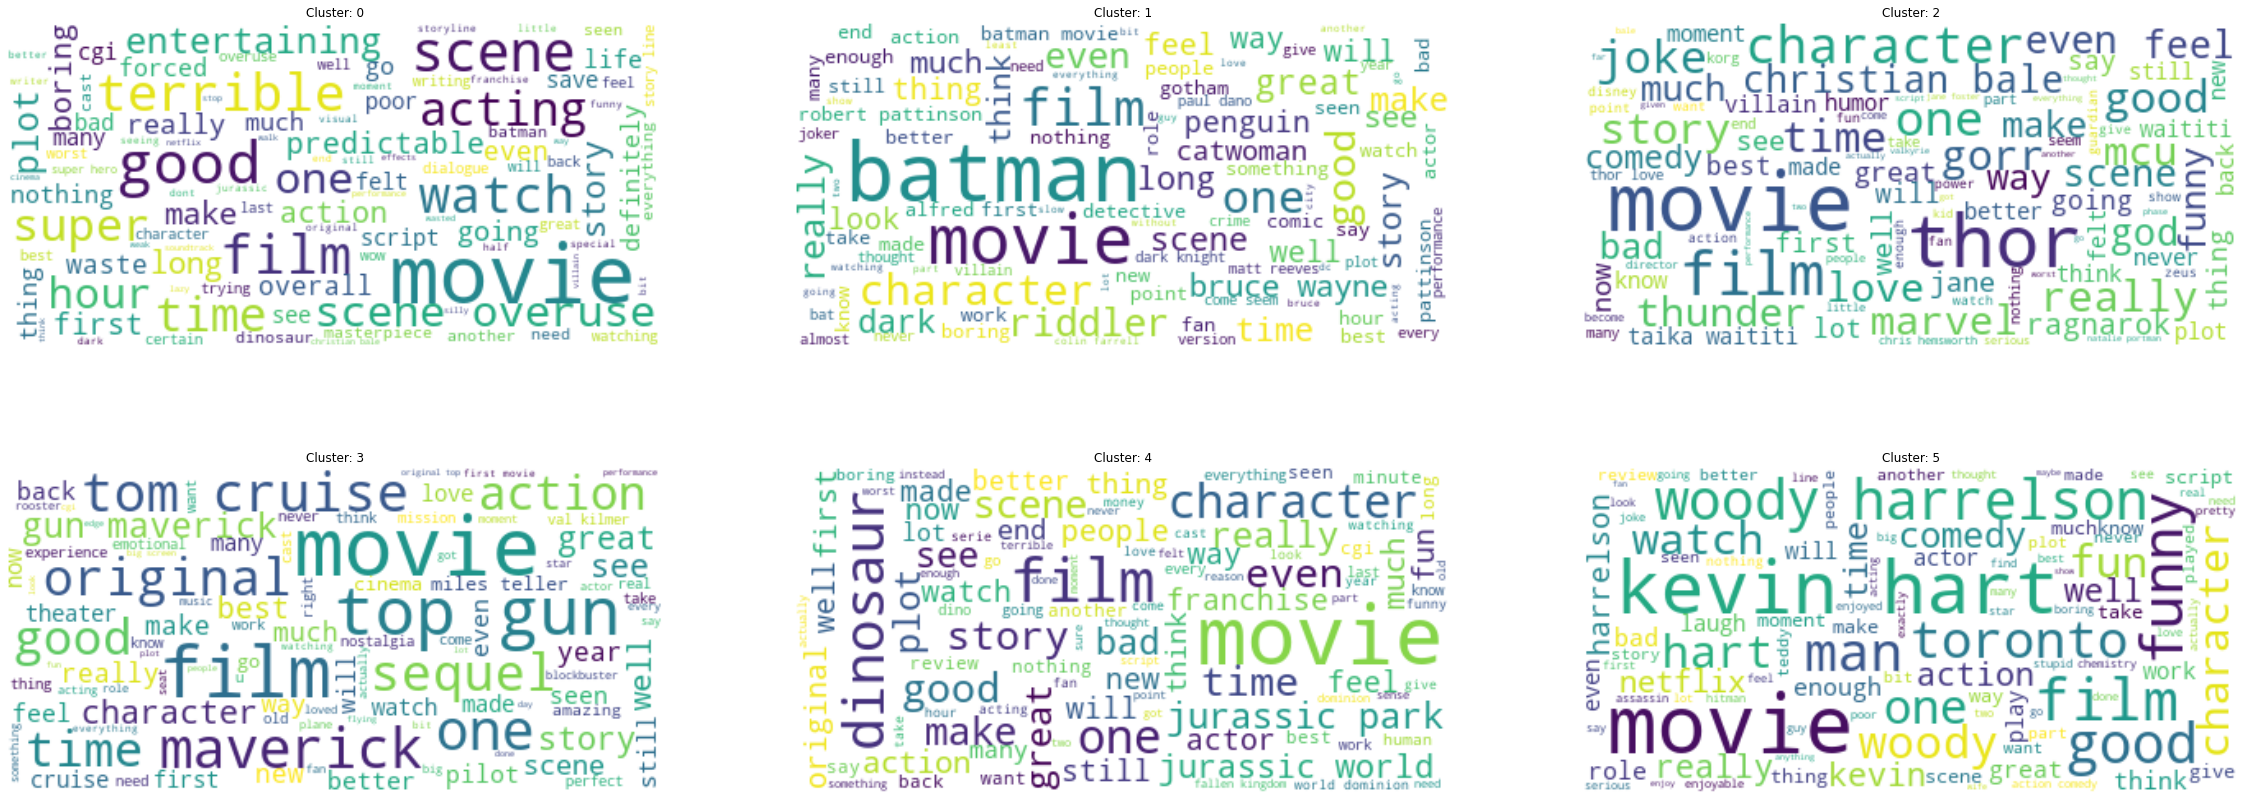

In [16]:
wordcloud_plt(6, 2, 3)

### k = 9

Top words per cluster:
Cluster 0 : terrible, entertaining, super, predictable, movie, watch, masterpiece, plot, definitely, film
Cluster 1 : movie, just, film, like, time, characters, plot, don, really, money
Cluster 2 : jurassic, dinosaurs, world, park, movie, film, dominion, characters, just, original
Cluster 3 : batman, movie, dark, riddler, pattinson, film, like, robert, bruce, just
Cluster 4 : kevin, hart, woody, harrelson, movie, toronto, fun, funny, man, netflix
Cluster 5 : thor, marvel, movie, bale, jokes, christian, love, thunder, film, mcu
Cluster 6 : maverick, gun, cruise, tom, film, movie, original, sequel, action, years
Cluster 7 : movie, good, great, story, original, watch, just, like, action, fun
Cluster 8 : funny, hart, kevin, movie, woody, comedy, bad, action, stupid, film


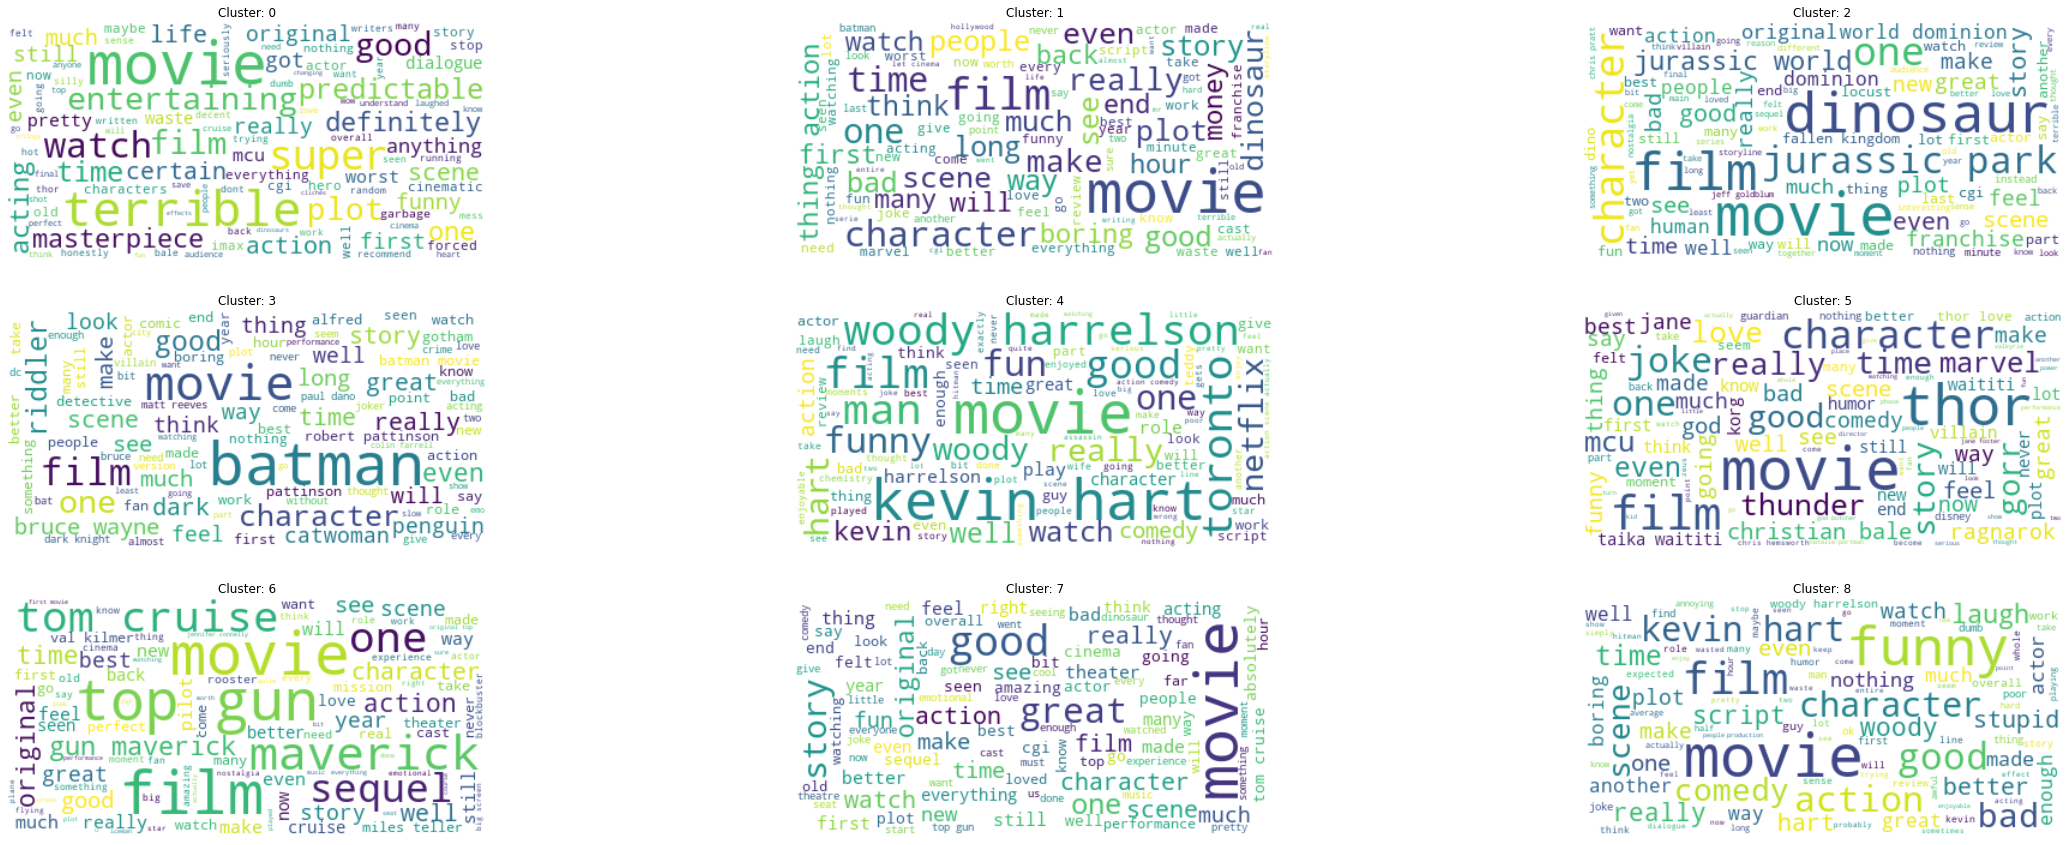

In [15]:
wordcloud_plt(9, 3, 3)

### k = 16

Top words per cluster:
Cluster 0 : entertaining, super, masterpiece, predictable, watch, life, film, movie, cinematic, changing
Cluster 1 : movie, like, really, just, time, film, didn, good, dinosaurs, movies
Cluster 2 : jurassic, dinosaurs, park, world, movie, film, dominion, just, original, characters
Cluster 3 : batman, movie, dark, riddler, pattinson, film, like, bruce, robert, just
Cluster 4 : kevin, hart, woody, harrelson, movie, funny, fun, just, comedy, watch
Cluster 5 : marvel, thor, disney, jokes, money, bad, movie, waste, funny, don
Cluster 6 : maverick, gun, cruise, tom, film, movie, original, sequel, action, years
Cluster 7 : movie, good, great, just, story, watch, fun, action, like, cgi
Cluster 8 : funny, hart, kevin, movie, bad, woody, stupid, just, laugh, comedy
Cluster 9 : overuse, horrible, jokes, scene, valkyrie, jane, money, bale, movie, thor
Cluster 10 : film, original, characters, story, good, movie, new, action, just, scenes
Cluster 11 : terrible, movie, good, ac

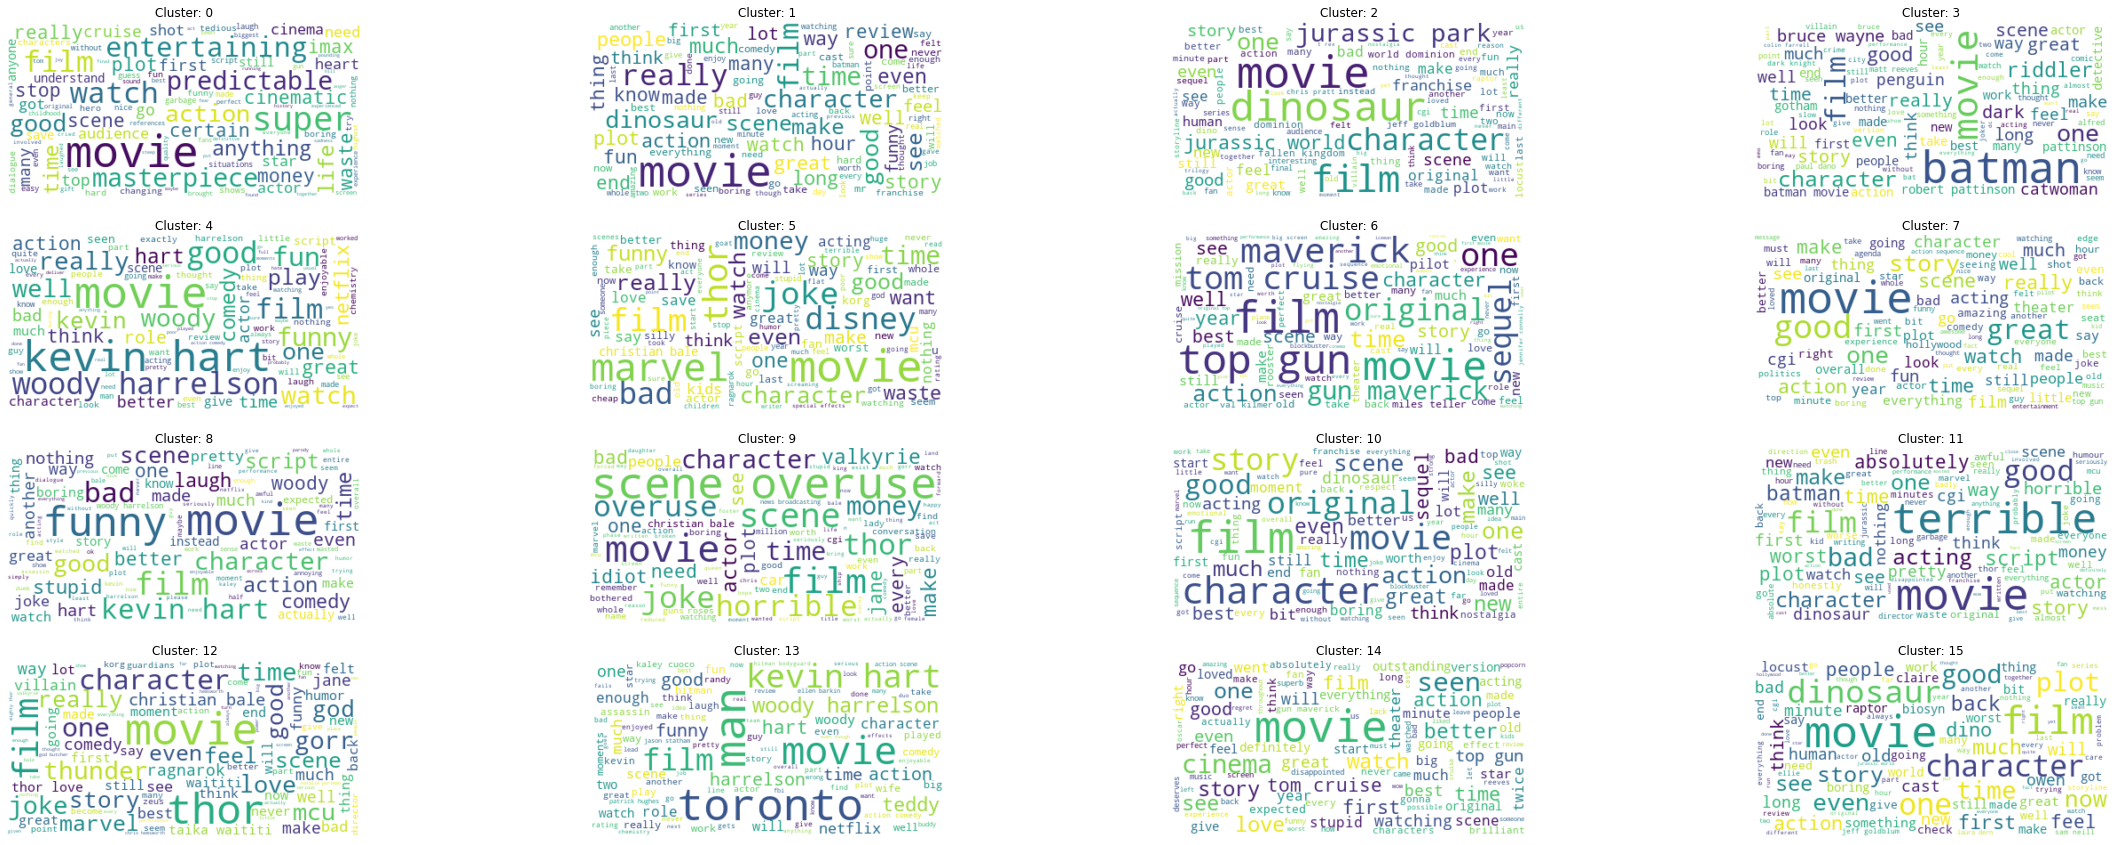

In [17]:
wordcloud_plt(16, 4, 4)

---
#### **2)** Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. 

```
Observing the clusters above, we can see that:

With k=6, Cluster 0 shows all kinds of mix-reviews, while other clusters grouped around commonalities in specific movies.

With k=9, Cluster 0 and Cluster 1 still shows some kinds of mix-reviews, while Cluster 7 clustered around possitive reviews. Other clusters grouped around commonalities in specific movies.  Cluster 4 and Cluster 8 clustered around 'The Man from Toronto' movie with main actors.

With k=16, Cluster 0 and CLuster 7 clustered around possitive reviews, while Cluster 11 clustered around negative reviews.  Other clusters grouped around commonalities in specific movies. We started to see one movie clustered into multiple clusters which doesn't seem to be any real definition of what the centroid is centered on. All of the clusters have the words film and movie in them which could be center points.
```

---
#### **3)** Explain which of the two clustering results from question 1 is preferable (if one of them is), and why. 

```
According to Question 2, my preferable cluster is k=9. This is because with the lower number of k (k=6), we do see clusters around specific movies, but they do not provide enough information.  With the higher k (k=16), we do see more information but some clusters become too scatter.  In my opinion, I would prefer k=9.  It gives 'about right' answer for this Homework.
```